# Effect of misspecification on GBI samples learned via emulator
...and normalizing constant.

Learn an emulator (e.g., SNLE) and sample from that to generate GBI distances, which is then used for GBI sampling

In [173]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from torch import zeros, ones, sqrt, tensor, as_tensor, float32
import numpy as np

from sbi.utils import BoxUniform, likelihood_nn
from sbi.utils.gbi import build_generalized_log_likelihood, GBIPotential, mse_dist
from sbi.inference import SNLE, RejectionPosterior, likelihood_estimator_based_potential

### Define simulator, simulate, train emulator

In [175]:
prior = BoxUniform(-ones(2), ones(2))
def simulator(theta):
    return theta ** 2 + torch.randn(theta.shape) * 0.1

In [176]:
_ = torch.manual_seed(0)
theta = prior.sample((1_000,))
x = simulator(theta)

density_estimator = likelihood_nn("nsf")
inference = SNLE(prior, density_estimator=density_estimator)
net = inference.append_simulations(theta, x).train(max_num_epochs=30)

 Training neural network. Epochs trained: 31

### Emulator samples are used to compute distances for theta

In [177]:
generalized_likelihood = build_generalized_log_likelihood(
    emulator=net,
    x_o=-0.5*torch.ones((1,2)),
    dist_func=mse_dist,
    n_per_theta=1_000
)
emulator_dists = generalized_likelihood(theta).detach()

In [178]:
emulator_dists.shape, theta.shape, x.shape

(torch.Size([1000]), torch.Size([1000, 2]), torch.Size([1000, 2]))

### Example 1

In [13]:
thetas = torch.linspace(-4, 4, 100)
x_mean = (thetas**2 - 2)**2

xo = -25*ones(1)

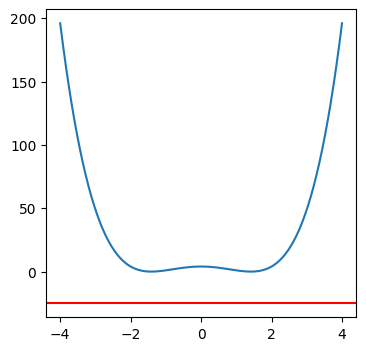

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
_ = ax.plot(thetas.numpy(), x_mean.numpy())
ax.axhline(xo.numpy(), c="r")
plt.show()

# Use the true simulator to infer the evidence

The method is the same as it would be for the trained neural net. However, to ensure that everything behaves as expected, this uses the actual simulator instead of the neural net.

In [15]:
likelihoods = torch.distributions.Normal((thetas**2 - 2)**2, 0.1*torch.ones(1))
s = likelihoods.sample((1000,))

In [16]:
dists = ((s - xo)**2).mean(dim=0)

In [17]:
all_z = []
all_beta = list(range(1, 2000, 1))
for beta in all_beta:
    func1 = torch.exp(-1/beta*dists) / sqrt(tensor(beta))
    normalizer = func1.max()
    # print(beta, normalizer)
    
    # fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    # _ = ax.plot(thetas.numpy(), func1.numpy())
    # plt.show()
    all_z.append(normalizer)

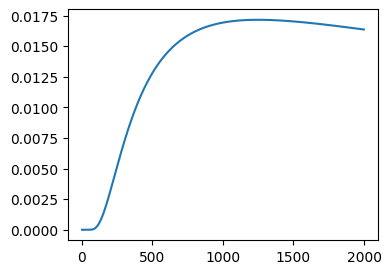

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(all_beta, all_z)

In [19]:
optimal_beta = all_beta[np.argmax(all_z)]
print(optimal_beta)

1249


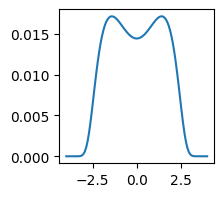

In [20]:
func1 = torch.exp(-1/optimal_beta*dists) / sqrt(tensor(optimal_beta))
normalizer = func1.sum()
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = ax.plot(thetas.numpy(), func1.numpy())
plt.show()

# Use the trained neural net to compute the evidence

This cell also differs from above in how $Z(\beta)$ is computed. Here, it computes it by actually integrating the x-grid of the likelihood. In the cell above, it simply assumed $Z \propto \sqrt{\beta}$. Due to this difference, the code currently fails (not sure we actually have to fix this?)

In [29]:
normalizing_constants = []
for beta in all_beta:
    gbi_potential = GBIPotential(
        prior=prior,
        gen_llh_fn=generalized_likelihood,
        beta=beta,
    )
    
    # Estimate Z_1(beta)
    theta_samples = prior.sample((1000,))
    x_samples = net.sample(1, context=theta_samples)[0]
    x_probs = net.log_prob(x_samples, context=theta_samples).exp().mean(dim=1)
    z1_of_beta = (gbi_potential(x_samples, track_gradients=False).exp() / x_probs).mean()
    
    # Estimate Z_2
    norm_constant = 0.0
    num_runs = 10
    for _ in range(num_runs):
        prior_samples = prior.sample((10,))
        norm_constant += gbi_potential(prior_samples, track_gradients=False).exp().mean() / z1_of_beta
    norm_constant /= num_runs
    normalizing_constants.append(norm_constant)

beta tensor(1.0000e-05)


/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


ValueError: Number of input items must be equal to number of context items.

In [31]:
normalizing_constants = torch.stack(normalizing_constants)

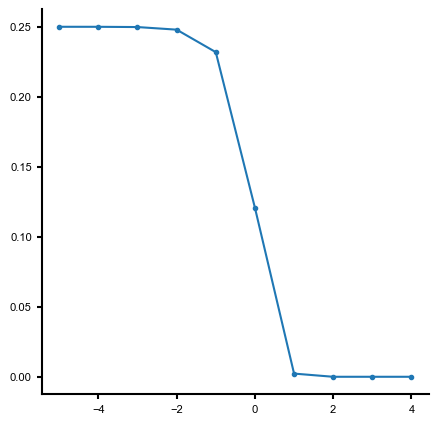

In [33]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(beta_range.log10().numpy(), normalizing_constants.numpy())
    ax.plot(beta_range.log10().numpy(), normalizing_constants.numpy())
    plt.show()